<img src="./img/HWNI_logo.svg"/>

# Tutorial - Two-Way ANOVA by Hand

In [ ]:
# makes our plots show up inside Jupyter
%matplotlib inline

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

/Users/charlesfrye/anaconda3/envs/neur299/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def mock_interaction_plot(results, title):

    plt.errorbar([0, 1], results[0,:], yerr=0.1,
                linewidth = 4, marker = 'o', markersize = 12,
                 markeredgecolor='k', markeredgewidth = 3,
                 label = "Plant Products");
    plt.errorbar([0, 1],results[1,:], yerr=0.1,
                linewidth = 4, marker = 'o', markersize = 12,
                 markeredgecolor='k', markeredgewidth = 3,
                 label = "No Plant Products");
    plt.yticks([]); plt.ylabel("Lifespan");
    plt.xticks([0, 1], ["Animal Products", "No Animal Products"]);
    plt.xlim([-0.5, 1.5]);
    plt.legend()
    plt.title(title);
    
def compare_interaction_plots(no_interaction, interaction):
    
    args = zip([no_interaction, interaction], ["No Interaction", "Interaction"])
    fig, axs = plt.subplots(1,2, figsize=(16,6))
    
    
    for ax, arg in zip(axs,args):
        plt.sca(ax)
        mock_interaction_plot(*arg)

In the previous section,
we worked out the One-Way ANalysis Of VAriance,
or ANOVA,
test for determining whether means differed across
varying levels of a single factor.

In this tutorial,
we extend the ANOVA test to simultaneous
variation of two or more factors.

## Extending ANOVA to Multiple Variables

With the One-Way ANOVA,
we were able to answer the question:
"is the mean of the observed variable different across the levels of the controlled variable?"
In our example experiment,
we determined that the mean of the activity in a certain brain region
varied across levels of the variable "task difficulty".

We determined whether this was the case by measuring the ratio of the
variance in group means to the
variance of the errors made when we used the group mean
to predict the observed value.
We compared the value of this ratio,
also known as the $F$ statistic,
to its (theoretical or simulated)
values under a null distribution
corresponding to totally random groupings of the data.

Now we'd like to answer the question:
"is the mean of the observed variable different across combinations of the levels of multiple controlled variables?"
For example,
we might want to know whether the mean activity of the brain region above
also varied across age groups.
More interestingly still,
we might want to know whether the effect of difficulty on brain activity
is modulated in some way by age.

### Interactions

In the parlance of ANOVA,
the lattermost question is about
*interactions* --
effects that arise when two variables
change together
and which are not predicted by looking at the two variables separately.

As an example,
consider two diet experiments:
one tested the effect on lifespan of cutting animal products entirely from the diet
and the other tested the same outcome of cutting plant products entirely from the diet.
Ignoring the practical difficulties of such an experiment,
let's say that both studies reported that their dietary exclusion
led to an increased lifespan, on average,
in participants, thanks to a significant ANOVA test.

It does not follow from this that
cutting both animal AND vegetable products entirely from your diet
will allow you to live longer:
on the contrary, you'd be left with nothing to eat,
which is surely deleterious to your health!

To clarify the nature of interactions,
let's plot some fictive data
from experiments where there is
and is not an interaction.

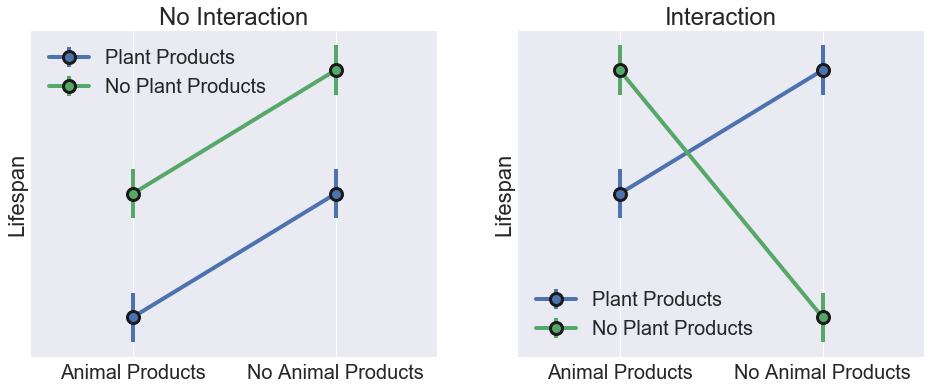

In [3]:
no_interaction = np.asarray([[1.,1.5],[1.5,2.]])
interaction = np.asarray([[1,1.5],[1.5,0.5]])
        
compare_interaction_plots(no_interaction, interaction)

The means of each group are indicated by the filled circles
and the error bars represent the standard deviation.

The plot on the left shows our lifespan data
in the case where cutting animal products
and cutting plant products have independent effects on lifespan.

Notice that the two lines have the same slope:
the change in lifespan induced by dropping animal products
when you've already dropped plant products
is the same as that induced by dropping animal products
without dropping plant products.
Alternatively and equivalently,
note that the gap between the two lines
(indicating the presence and absence of plant products in the diet)
is the same for diets with and without animal products.

This is unlikely to be the case in real life
for this combination of experimental manipulations.
The right plot shows a more realistic outcome:
while dropping plant products and dropping animal products
both have a beneficial effect on lifespan,
dropping both has a negative effect on lifespan.
As before, we can see the interaction between our two diets
by looking at the plot:
the lines now no longer have the same slope,
nor is the gap between the two filled circles
the same size on the left as on the right.

Of course,
the chance of getting lines that have exactly the same slope
is almost zero for real data,
even if there is no effect.
To rigorously determine whether an interaction is
unlikely to occur due to chance,
we'll need to come up with a statistic
that captures both the size of this difference
and the magnitude of the variability in the data.
Then we can compare the value of this statistic
on our data to its null distribution
and determine how likely getting such a value
would be under the null hypothesis.

Once again,
our statistic will be the $F$-statistic,
but for different choices of explained and unexplained variances
on the top and bottom of the ratio,
and so our test will be an ANOVA test.
When there are two factors being tested,
this is called a *Two-Way ANOVA*
or a *Two-Factor ANOVA*.

Before diving into the details of the Two-Way ANOVA,
I'd like to note that
[Sir Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher),
inventor of the ANOVA and numerous other fundamental statistics and statistical concepts,
once said, roughly,
that the rigorous hypothesis tests he invented were to be used simply
to determine whether the patterns we see in graphs reflect real patterns or the effect of chance.
With that in mind,
it's highly recommended that you take a look at your data before running any statistical tests on it!

## Two-Way ANOVA

As we did before,
we first take a look at the (linear) data model
underlying the ANOVA.

In English (rigorous math shorthand below):
we break down the value of the dependent variable $Y$
we measured for each data point into five pieces:
the grand mean,
the effect of being in group $i$ of variable $A$,
the effect of being in group $j$ of variable $B$,
the interaction effect of being in both groups $i$ and $j$,
and the
"unknown effects"
that we didn't measure,
which are specific to each observation.
For simplicity's sake,
we assume that each group has the same number of observations,
which saves us a bunch of book-keeping,
but this is not a limitation of the ANOVA test.

The first of our pieces is the grand mean,
or the average of all of our measurements.
We then add to that grand mean the effect of being in group $i$ of
the first of our two variables, $A$.
This is,
as it was in the original One-Way ANOVA,
the difference between the mean of group $i$ of $A$
and the grand mean.
Just as,
when calculating the grand mean,
we include observations from all groups,
when we calculate the mean of group $i$ of variable $A$,
we include all the groups of the second variable.

We also need to incorporate the effect of that second variable, $B$,
so now we compute the difference between the mean of group $j$ of $B$
and the grand mean,
once again including observations
from all levels of the first variable, $A$.

So far, so similar to the One-Way ANOVA.
The first (and only)
really new idea is the measurement of the interaction effect.
If there were no interaction,
we'd be able to predict the mean of
the observations that are in
both group $i$ of $A$ and in group $j$ of $B$
by adding the effect of being in group $i$ and the effect of being in group $j$
to the grand mean.
So to measure the interaction effect,
we just subtract those three numbers from each of the observations
in the combined group $ij$ and take an average.

Anything left over must be due to unknown effects
(also known as *residuals* or the *error*,
and usually symbolized by the Greek letter $\epsilon$).
So we subtract the grand mean, the group effects, and the interaction effect
from each data point,
and whatever we have left is the effect of unknown factors.

The first two lines below
translate this model into
math with English words
and then into a more traditional collection of symbols,
which are then defined concretely.

$${\scriptsize\begin{align}
    &\text{Observation}\ k\ \text{in Groups}\ i\ \&\ j\ 
    &= \ &\text{Grand Mean}\ 
    &+\ &\text{Group Effect A}_i\
    &+\ &\text{Group Effect B}_j\
    &+\ &\text{Interaction AB}_{ij}
    &+ \ &\text{Unknown Effects}_{ijk} \\
    &Y_{ijk} 
    &= \ &\mu_\text{grand} \ 
    &+\ &A_i\
    &+\ &B_j\
    &+\ &AB_{ij}
    &+ \ &\epsilon_{ijk}
\end{align}}$$

$${\scriptsize
\begin{align}
    \mu_\text{grand} &= \frac{1}{N} \sum_{ijk} Y_{ijk} \\
    A_i &= \frac{1}{N_{\text{group}\ i}} \sum_{jk} Y_{ijk} - \mu_\text{grand} \\
    B_j &= \frac{1}{N_{\text{group}\ j}} \sum_{ik} Y_{ijk} - \mu_\text{grand} \\
    AB_{ij} &= \frac{1}{N_{\text{group}\ ij}} \sum_{k} Y_{ijk} - A_i - B_j - \mu_\text{grand} \\
    \epsilon_{ijk} &= Y_{ijk} - A_i - B_j - AB_{ij}
\end{align}}
$$

These equations are just a convenient shorthand for the description above.
It's not particularly useful to memorize them;
it's much more valuable to understand the intuition of the ANOVA test.

## Multi-Way ANOVA

Below,
we'll implement a Two-Way ANOVA by hand in order to firm up our understanding of the ANOVA test.
But first,
we note in passing that there's no reason to stop at just two independent variables.
The same model can be extended to $k$ variables without much difficulty.
We measure group effects and two-way interactions as above:
we ignore the group identity for every other independent variable.
For three-way interactions (e.g. $ABC$), we ignore all but three of the group identities when we do our average,
and we subtract off the two-way interactions ($AB$, $BC$, and $AC$) and the group effects ($A$, $B$, and $C$),
just as we subtracted off the group effects when calculating interaction effects.

ANOVAs with more than two independent variables are called
*Multi-Way ANOVAs*.
The book-keeping with indices and types of interactions becomes more labor-intensive and less enlightening as the number of interactions goes up,
so we won't go through Multi-Way ANOVAs in detail.
Luckily, at a high level, sufficient for understanding and using,
but not personally implementing,
Multi-Way ANOVA,
the model remains quite simple:

$$\begin{align}
    &\text{Observation}
    &= \ &\text{Grand Mean}\ 
    &+\ &\sum{\text{Group Effects}}\
    &+\ &\sum{\text{Interactions}}\
    &+\ &\text{Observation-Specific Unknown Effects}
\end{align}$$

Though in principle there's no limit to how many variables can be included in an ANOVA,
there are serious practical concerns.
If there are four independent variables, $ABCD$,
then there are 6 two-way interactions,
$AB$, $AC$, $AD$, $BC$, $BD$, and $CD$,
which are needed to estimate the three-way and four-way interactions.
To accurately estimate these values,
we need at least 10 observations apiece,
or more preferably more than 30.
This requires on the order of 100 data points,
and that's before we consider whether those counts are sufficient for a well-powered study.

If we increase the number of independent variables more,
the largest number of interactions increases very rapidly:
for seven independent variables,
the number of three-way interactions is 35,
while for ten independent variables,
the number of five-way interactions is 252
(these numbers are calculated using the
["choose" function](https://en.wikipedia.org/wiki/Combination)).
Adding independent variables to an ANOVA will quickly
swamp your ability to collect more data.

Worse still,
the statistical validity of the ANOVA test goes down
as the number of tested interactions goes up.
We'll cover this in more detail in the lab for this section.

## Implementing Two-Way ANOVA

Below, we implement a Two-Way ANOVA.
This is intended for educational purposes.
If you wish to perform an ANOVA on research data,
you should use a statistical software package.
In the lab for this section, we'll see how to use these packages
to perform Two-Way and Multi-Way ANOVAs.

### About the Dataset

The data for this lab is simulated.

After learning of [Nemeroff, Heim, et al.](http://www.pnas.org/content/100/24/14293.full)'s finding that psychotherapy is more effective at treating depression in individuals with childhood trauma, you become interested in whether the same might be true for treating anxiety.

You run a clinical experiment in which individuals with and without childhood trauma are treated with a placebo, the standard of care for psychotherapy (CBT, or 
["Cognitive Behavioral Therapy"](https://en.wikipedia.org/wiki/Cognitive_behavioral_therapy)),
or the standard of care for pharmacotherapy
(an [anxiolytic GABA agonist](https://en.wikipedia.org/wiki/Anxiolytic)).
As an aside: in actual clinical studies, treatment with a placebo is considered unethical if there's already a standard of care, and a proper clinical trial compares alternative treatments to standard treatments.

The results of your experiment are summarized in the table `anxiety_dataset.csv`.

### Loading the Data

We begin by loading the data and taking a look at the data frame.

In [4]:
data = pd.read_csv('./data/anxiety_dataset.csv',index_col=0)

In [5]:
data.sample(10)

,treatment,trauma,anxiety_reduction
subjectID,,,
20,cbt,False,3.8
4,placebo,True,2.9
5,drug,True,5.5
13,drug,False,9.0
16,cbt,False,7.4
20,drug,False,6.9
1,placebo,True,2.8
10,placebo,True,2.7
6,drug,True,2.7


Normally, this would be the point at which we would visualize the data.
Instead, we'll leave that for the lab for this section.

As previously, we'll build a pandas data frame to store all of the information for our ANOVA test.

In [6]:
N = len(data)

anova_frame = data.copy()

anova_frame.sample(10)

,treatment,trauma,anxiety_reduction
subjectID,,,
9,cbt,True,7.20
9,drug,True,5.00
8,placebo,True,3.00
14,drug,False,6.00
15,drug,False,7.40
8,drug,True,3.45
1,placebo,True,2.80
17,drug,False,6.80
18,placebo,False,3.30


We'll need the possible values of our treatment and trauma groups
in order to calculate means and effects,
so we grab those using the `unique` method.

In [7]:
treatments = data.treatment.unique()
traumas = data.trauma.unique()

### Computing Model Terms: Means and Residuals

We start by calculating the grand and individual variable means, using the `groupby` method when necessary.

In [8]:
grand_mean = anova_frame.anxiety_reduction.mean()
treatment_means = anova_frame.groupby("treatment").anxiety_reduction.mean()
trauma_means = anova_frame.groupby("trauma").anxiety_reduction.mean()

For the interaction term,
we do a "double `groupby`" by passing a list of column names to group on to the `groupby` method,
instead of the name of a single column.

In [9]:
interaction_means = anova_frame.groupby(["treatment","trauma"]).anxiety_reduction.mean()

In [10]:
interaction_means

treatment  trauma
cbt        False     5.070
           True      6.060
drug       False     7.360
           True      4.865
placebo    False     2.990
           True      2.660
Name: anxiety_reduction, dtype: float64

`groupby` is one of the most powerful tools in the pandas toolkit,
and creative uses of it can solve lots of data problems.
Check out
[this tutorial](https://www.dataquest.io/blog/pandas-tutorial-python-2/)
for more on using `groupby`.

Now,
we use the combination of a selector
(a binary `Series` that picks out all values in a dataframe
corresponding to `1`s in the `Series`)
and the `.loc` method
to add columns for the main effects of treatment and trauma
and the interaction effect of trauma and treatment.
We use `.loc` to find things using keys and
we use selectors to find things using logical statements.
`.loc` is useful for indexing into the `groupby` objects,
while selectors are useful for indexing into the `anova_frame`.

We covered selectors in the pandas tutorial, but look back if you need a refresher. If you're confused or curious about how `.loc` works, check out
[this tutorial](http://www.shanelynn.ie/select-pandas-dataframe-rows-and-columns-using-iloc-loc-and-ix/). 

In [11]:
anova_frame["grand_mean"] = grand_mean

for trauma in traumas:
    selector = (anova_frame.trauma == trauma)
    anova_frame.loc[selector,"trauma_main_effect"] = trauma_means.loc[trauma]-grand_mean
    
for treatment in treatments:
    selector = (anova_frame.treatment == treatment)
    anova_frame.loc[selector,"treatment_main_effect"] = treatment_means.loc[treatment]-grand_mean
    
for trauma in traumas:
    for treatment in treatments:
        selector = (anova_frame.treatment == treatment) & (anova_frame.trauma == trauma)
        anova_frame.loc[selector,"interaction_effect"]  = interaction_means.loc[treatment,trauma] - \
            anova_frame.trauma_main_effect[selector] - anova_frame.treatment_main_effect[selector] - grand_mean            

Lastly, we calculate the residual error.
We calculate the residual error simply by subtracting columns of `anova_frame`.

In [12]:
anova_frame["residual"] = anova_frame.anxiety_reduction - anova_frame.grand_mean - \
                            anova_frame.trauma_main_effect - anova_frame.treatment_main_effect - \
                            anova_frame.interaction_effect
    
anova_frame.sample(10)

,treatment,trauma,anxiety_reduction,grand_mean,trauma_main_effect,treatment_main_effect,interaction_effect,residual
subjectID,,,,,,,,
15,cbt,False,4.6,4.834167,0.305833,0.730833,-0.800833,-0.470
6,cbt,True,3.0,4.834167,-0.305833,0.730833,0.800833,-3.060
1,placebo,True,2.8,4.834167,-0.305833,-2.009167,0.140833,0.140
3,cbt,True,5.0,4.834167,-0.305833,0.730833,0.800833,-1.060
14,placebo,False,2.3,4.834167,0.305833,-2.009167,-0.140833,-0.690
10,placebo,True,2.7,4.834167,-0.305833,-2.009167,0.140833,0.040
4,placebo,True,2.9,4.834167,-0.305833,-2.009167,0.140833,0.240
17,drug,False,6.8,4.834167,0.305833,1.278333,0.941667,-0.560
2,drug,True,6.3,4.834167,-0.305833,1.278333,-0.941667,1.435


Compare the above Python expression to the mathematical expression below
and make sure you can match up terms.

$$
\begin{align}
    \epsilon_{ijk} &= Y_{ijk} -\mu_\text{grand} - A_i - B_j - AB_{ij}
\end{align}
$$

The matrix above is called a
*decomposition matrix*.
With it in hand,
we can perform our ANOVA test.

### Calculating Sums of Squares, Mean Squares, and Degrees of Freedom

As before,
we need to calculate sums of squares,
convert them to mean squares
using degrees of freedom,
and then calculate ratios of
the mean squares of our effects
to the residual mean square in order
to get our $F$-statistic.
If the motivation for performing any of these steps is unclear,
review the tutorial on One-Way ANOVA --
the reasoning is unchanged.

We begin by calculating the total,
mean,
treatment,
trauma,
interaction,
and residual sums of squares.

As before,
we'll store them in a dictionary,
keyed by their name.

In [13]:
sum_of_squares = {}

keys = ["total","grand_mean","trauma","treatment","interaction","residual"]

columns = [anova_frame.anxiety_reduction,
           anova_frame.grand_mean,
           anova_frame.trauma_main_effect,
           anova_frame.treatment_main_effect,
           anova_frame.interaction_effect,
           anova_frame["residual"]]

for key,column in zip(keys,columns):
    sum_of_squares[key] = np.sum(np.square(column))
    
sum_of_squares

{'grand_mean': 1402.1500416666663,
 'interaction': 30.95808333333337,
 'residual': 76.082250000000002,
 'total': 1638.9025000000004,
 'trauma': 5.6120416666666948,
 'treatment': 124.10008333333334}

To calculate mean squares,
we need the degrees of freedom
for each of the sums of squares above.
Again, we store them in a dictionary keyed by name.

In [14]:
dof = {}

keys = ["total","grand_mean","trauma","treatment","interaction","residual"]
vals = [N,1,
        len(traumas)-1,
        len(treatments)-1,
        (len(traumas)-1)*(len(treatments)-1),
        N-len(traumas)*len(treatments)]

for key,val in zip(keys,vals):
    dof[key] = val
    
dof

{'grand_mean': 1,
 'interaction': 2,
 'residual': 54,
 'total': 60,
 'trauma': 1,
 'treatment': 2}

Using the dictionaries `sum_of_squares` and `dof`, we compute the mean square values for all of the keyed quantities.

In [15]:
mean_square = {}

for key in keys:
    mean_square[key] = sum_of_squares[key]/dof[key]
    
mean_square

{'grand_mean': 1402.1500416666663,
 'interaction': 15.479041666666685,
 'residual': 1.4089305555555556,
 'total': 27.315041666666673,
 'trauma': 5.6120416666666948,
 'treatment': 62.050041666666672}

### Completing the ANOVA: The $F$ and $p$ statistics

The $F$-statistic for each main effect and for the interaction is,
as before,
calculated as a ratio of the mean square for the group
over the mean square of the residual.

In [16]:
F = {}

for key in ["treatment","trauma","interaction"]:
    F[key] = mean_square[key]/mean_square["residual"]

F

{'interaction': 10.986376585865967,
 'trauma': 3.9831925317666279,
 'treatment': 44.040525221060108}

Lastly, we compute the $p$ value using `scipy.stats.f.cdf`.

In [17]:
for effect in F.keys():
    print(effect)
    print("\t"+str(1-scipy.stats.f.cdf(F[effect],dof[effect],dof["residual"])))

treatment
	4.53059811889e-12
trauma
	0.0510105729778
interaction
	9.92816894022e-05


This completes our implementation of the Two-Way ANOVA.
Aside from a few changes to the construction of the decomposition matrix,
the ANOVA proceeded much the same as the One-Way ANOVA.

To check our work here and learn to use built-in methods
for Two- and Multi-Way ANOVAs,
check out [Lab A](Lab A - Two-Way ANOVA.ipynb).
To learn more about issues of multiple comparisons in the context of multi-way ANOVAs,
check out [Lab B - Multiple Comparisons and ANOVA](Lab B - Multiple Comparisons and ANOVA.ipynb).